In [1]:
import time
import torch

from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset

import flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper
from Distributions2 import *
# visualization
import matplotlib.pyplot as plt

from matplotlib import cm
from flow import build_ttf_m
from network import MLP,MLP_TailParam,MLP_TailParam2,MLP2
from torch.autograd.functional import jacobian
from torch.distributions import Independent, Normal
from extreme_transforms import TailAffineMarginalTransform_SeparateNetParam
from scaler_grad import NativeScalerWithGradNormCount as NativeScaler
# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [2]:
# ll=TailAffineMarginalTransform_SeparateNetParam().fwd_dTTF_dz(torch.randn(3,2),torch.randn(3,8))
# ll.shape

In [3]:
import torch
z=torch.rand(12)
z

tensor([0.5833, 0.0371, 0.8450, 0.2545, 0.3316, 0.1159, 0.8682, 0.1898, 0.3330,
        0.5248, 0.5007, 0.3638])

In [4]:
z.reshape(4,3)

tensor([[0.5833, 0.0371, 0.8450],
        [0.2545, 0.3316, 0.1159],
        [0.8682, 0.1898, 0.3330],
        [0.5248, 0.5007, 0.3638]])

In [5]:
!nvidia-smi

Wed May  7 17:54:08 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P8               6W /  50W |    600MiB /  4096MiB |     36%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)
seed=42

Using gpu


## Sampling data

c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\Distributions2.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob=torch.exp(i.log_prob(torch.tensor(samples)))


tensor(-6.1741)

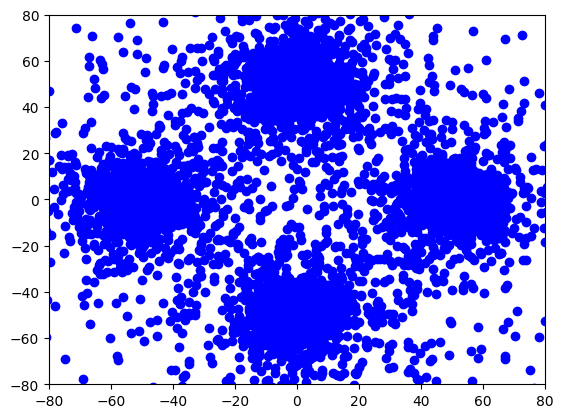

In [7]:
#PRINT MIX OF STUDENT-T
dof_og=1
ST_DATA,objectz=samplestudentT_4(50,dof_og,40000)
plt.ylim((-80,80))
plt.xlim((-80,80))
plt.scatter(ST_DATA[:,0],ST_DATA[:,1],c="blue")
studentT_4_likelihood(objectz,ST_DATA).mean()

In [8]:
#GETTING THE Data split and TAIL INDEX ESTIMATES
from generate_splits import generate_data_split



In [9]:
Data_Splt=generate_data_split('gppg', seed, 'dummy',ST_DATA)


100%|██████████| 2/2 [00:47<00:00, 23.90s/it]


In [10]:
ST_DATA.shape

torch.Size([40000, 2])

In [11]:
Data_Splt['metadata']

{'dfs': [1.1119684011771795, 0.9461591723366531],
 'pos_dfs': [0.0, 1.0584125863547804],
 'neg_dfs': [0.6078124467894714, 0.870418293978243],
 'mean': [-2.426814, -0.6382829],
 'std': [350.42422, 127.15294],
 'seed': 42}

In [12]:
# normal_numbers = torch.randn_like(ST_DATA).float()
# normal_numbers.shape

In [13]:
pos_df_list=[]
neg_df_list=[]
timez=[]

In [14]:
# for u in range(10):
#     t=u+1
#     timez.append(t)
#     print(t)
    # dummy=(t/10)*ST_DATA+(1-(t/10))*normal_numbers
    # DS=generate_data_split('gppg', seed, 'dummy',dummy)
    # pos_df_list.append(DS['metadata']['pos_dfs'])
    # neg_df_list.append(DS['metadata']['neg_dfs'])

    # print(DS['metadata']['pos_dfs'],DS['metadata']['neg_dfs'])
    

In [15]:
print(pos_df_list)
# [[0.0, 1.0742647053958416], [0.0, 1.0635387684247863], [0.0, 1.0533778075427342], [0.0, 1.0546965052329922], [0.0, 1.0851012672208165], [0.0, 1.0567570626199707], [0.0, 1.0573475314512493], [0.0, 1.0577909663454523], [0.0, 1.0581359633719218], [0.0, 1.0584125863547804]]


[]


In [16]:
print(neg_df_list)
# [[0.6851722402902292, 0.8799796130565829], [0.6826762668016684, 0.9779604950557927], [0.6818468191119482, 0.865970792231052], [0.6814326901095558, 0.8642392769740743], [0.5581180463185773, 0.8679604320263086], [0.6810189643377806, 0.8687786704403533], [0.7025260238775655, 0.8693635052873896], [0.765573192789264, 0.8698029076975606], [0.558420102518713, 0.87014467648119], [0.6806880182729251, 0.870418293978243]]

[]


In [17]:
# pos_df_list= [[0.0, 1.0742647053958416], [0.0, 1.0635387684247863], [0.0, 1.0533778075427342], [0.0, 1.0546965052329922], [0.0, 1.0851012672208165], [0.0, 1.0567570626199707], [0.0, 1.0573475314512493], [0.0, 1.0577909663454523], [0.0, 1.0581359633719218], [0.0, 1.0584125863547804]]
# neg_df_list= [[0.6851722402902292, 0.8799796130565829], [0.6826762668016684, 0.9779604950557927], [0.6818468191119482, 0.865970792231052], [0.6814326901095558, 0.8642392769740743], [0.5581180463185773, 0.8679604320263086], [0.6810189643377806, 0.8687786704403533], [0.7025260238775655, 0.8693635052873896], [0.765573192789264, 0.8698029076975606], [0.558420102518713, 0.87014467648119], [0.6806880182729251, 0.870418293978243]]

In [18]:
# timez=[0,1]
# pos_df_list=[[0.4,0.45],[0.45, 0.48584125863547804]]
# neg_df_list=[[0.42,0.46],[0.46, 0.48]]


In [19]:
# degree = 1
# coeffs_Y1_p = np.polyfit(timez, torch.tensor(pos_df_list)[:,0], degree)
# coeffs_Y2_p = np.polyfit(timez, torch.tensor(pos_df_list)[:,1], degree)
# coeffs_Y1_n = np.polyfit(timez, torch.tensor(neg_df_list)[:,0], degree)
# coeffs_Y2_n = np.polyfit(timez, torch.tensor(neg_df_list)[:,1], degree)


# # torch.tensor(neg_df_list)[:,0],np.polyval(coeffs_Y1_n,timez)



In [20]:
#  torch.tensor(neg_df_list)[:,0],np.polyval(coeffs_Y1_n,[0,0.1,0.2,0.8,0.9])

In [21]:
# torch.tensor(neg_df_list)[:,0]

## Building the Tail Model

In [22]:
# def ttf_rqs(dim, dfs):
#     return flows.build_ttf_m(
#         dim,
#         model_kwargs=dict(
#             fix_tails=False,
#             pos_tail_init=[
#                 float(t.cpu()) for t in torch.distributions.Uniform(low=0.05, high=1.0).sample([dim])
#             ],
#             neg_tail_init=[
#                 float(t.cpu()) for t in torch.distributions.Uniform(low=0.05, high=1.0).sample([dim])
#             ]
#         )
#     )


# def ttf_rqs_fix(dim, dfs):
#     return build_ttf_m(
#         dim,
#         model_kwargs=dict(
#             fix_tails=True,
#             pos_tail_init=[1 / df if df != 0.0 else 1e-4 for df in dfs['metadata']['pos_dfs']],  #DIFFFERENT FROM MAIN CODE
#             neg_tail_init=[1 / df if df != 0.0 else 1e-4 for df in dfs['metadata']['neg_dfs']],  #DIFFFERENT FROM MAIN CODE
#         )
#     )

In [23]:
# training arguments
lr = 0.0001
batch_size = 4096
iterations = 800*4
print_every = 10
hidden_dim = 512
dimension=2
device
# velocity field model init
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) #PREVECTOR FIELD
Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=8).to(device) #LAMBDA +,- , MEAN , SCALE
noise2data=TailAffineMarginalTransform_SeparateNetParam().to(device)  #TAKES FLOW FROM VF AND tAIL PARAM TO GEN A HEAVY TAIL DIST (there are no new param inside)


In [24]:
# Tail_paramNet.load_state_dict(torch.load('tailmodelv3.pth'))
# Tail_paramNet.train()
# # vf.load_state_dict(torch.load("modelv3.pth"))
# # vf.train()

In [25]:
trn_ix = Data_Splt["split"]["trn"]
val_ix = Data_Splt["split"]["val"]
tst_ix = Data_Splt["split"]["tst"]

mean = torch.tensor(0)#torch.tensor(Data_Splt['metadata']["mean"])
scale = torch.tensor(1)#torch.tensor(Data_Splt['metadata']["std"])

#I AM NOT NORMALISING THE TARGET
x_trn =(ST_DATA[trn_ix] - mean) / scale
x_val =(ST_DATA[val_ix] - mean) / scale
x_tst =(ST_DATA[tst_ix] - mean) / scale

In [26]:
# x_trn2=torch.clip(x_trn,-800,800)
# plt.scatter(x_trn2[:,0],x_trn2[:,1])
# plt.show()

In [27]:
def reverse_normalization(x):
    y=x
    # y=(x*scale.float().to(device))+mean.float().to(device)
    return(y)
    

In [28]:
train_dataset = TensorDataset(x_trn)


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Batch JACOBIAN EXAMPLE

In [29]:
import torch
import torch
from functorch import vmap, jacrev

# # Define a simple model with two inputs
# class MyModel(torch.nn.Module):
#     def forward(self, x, y):
#         return x**2 + y**3  # Example function

# # Instantiate the model
# model = MyModel()

# # Batched Inputs (batch_size=2, feature_dim=2)
# x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)  
# y = torch.tensor([[3.0, 4.0], [5.0, 6.0]], requires_grad=True)

# # Use jacrev to compute the Jacobian for each input
# jacobian_fn = jacrev(model.forward, argnums=(0, 1))  # Differentiate w.r.t x and y
# batched_jacobian = vmap(jacobian_fn)(x, y)

# # Extract Jacobians w.r.t. x and y
# jacobian_x, jacobian_y = batched_jacobian

# print("Jacobian w.r.t x:\n", jacobian_x)
# print("Jacobian w.r.t y:\n", jacobian_y)


In [30]:
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight)  # Xavier Uniform Initialization
#         nn.init.zeros_(m.bias)  # Initialize bias to zero

# vf.apply(init_weights)  # Apply initialization

# Tail_paramNet.apply(init_weights)  # Apply initialization


In [31]:
jo=0 #counter
# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
# optim = torch.optim.Adam(vf.parameters(), lr=lr/5,weight_decay=1e-4)
# optim2=torch.optim.Adam(Tail_paramNet.parameters(), lr=lr/10)#,weight_decay=1e-3)
# optim3=torch.optim.Adam(noise2data.parameters(),lr=lr)
# #dof 1
optim = torch.optim.Adam(vf.parameters(), lr=lr,weight_decay=1e-3)
optim2=torch.optim.Adam(Tail_paramNet.parameters(), lr=lr,weight_decay=1e-3)#,weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.LinearLR(optim2, start_factor=lr*10, end_factor=0.0, total_iters=iterations*len(train_loader))
loss_scaler = NativeScaler()

predefined_tail_param=False
positive_tail_param=None
negative_tail_param=None

#dof 2
# optim = torch.optim.RMSprop(vf.parameters(), lr=lr/10)
# optim2=torch.optim.RMSprop(Tail_paramNet.parameters(), lr=lr/10)

In [32]:
def nan_hook(self, inp, output):
    if not isinstance(output, tuple):
        outputs = [output]
    else:
        outputs = output

    for i, out in enumerate(outputs):
        nan_mask = torch.isnan(out)
        if nan_mask.any():
            print("In", self.__class__.__name__)
            raise RuntimeError(f"Found NAN in output {i} at indices: ", nan_mask.nonzero(), "where:", out[nan_mask.nonzero()[:, 0].unique(sorted=True)])

for submodule in noise2data.modules():
    submodule.register_forward_hook(nan_hook)

In [33]:
import numpy as np
dimz=2
tail_param_perdim=4
rowsz=np.array(list(range(dimz*tail_param_perdim)))%dimz
colsz=list(range(dimz*tail_param_perdim))
flat_indicesz = dimz*tail_param_perdim * rowsz + colsz  # Flattened index in 3x12 matrix
MMM = torch.zeros((dimz*dimz*tail_param_perdim, dimz*tail_param_perdim), dtype=torch.float32)
MMM[flat_indicesz, torch.arange(dimz*tail_param_perdim)] = 1.0

In [34]:

# train
start_time = time.time()
for i in range(iterations):
    for data in train_loader:
        optim.zero_grad()
        optim2.zero_grad()
        # sample data : in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
        # print(data[0].shape)
        x_1=data[0].float().to(device)
        x_0 = torch.randn_like(x_1).float().to(device)

        # x_1=data2noiseTransform(x_1_H)[0] #Heavy tail to light tail
       


        # sample time 
        # t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)
        if i<(3*iterations)//4:
            t = 1-torch.sqrt(1-torch.rand(x_1.shape[0])).to(device) #best
        else:
            t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)
        # t = torch.rand(x_1.shape[0]).to(device)

        # t = torch.sqrt(torch.rand(x_1.shape[0])).to(device)

        if(predefined_tail_param):
            positive_tail_df=torch.cat([torch.tensor(np.polyval(coeffs_Y1_p,t.cpu())).unsqueeze(1),torch.tensor(np.polyval(coeffs_Y2_p,t.cpu())).unsqueeze(1)],1)
            negative_tail_df=torch.cat([torch.tensor(np.polyval(coeffs_Y1_n,t.cpu())).unsqueeze(1),torch.tensor(np.polyval(coeffs_Y2_n,t.cpu())).unsqueeze(1)],1)
            # print(positive_tail_df.shape) #predefined_tail_param
            positive_tail_param=1/(positive_tail_df+1e-4).to(device)
            negative_tail_param=1/(negative_tail_df+1e-4).to(device)
        # print(positive_tail_param[0:5,:])

        # print(bx)

        # sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        x_t,time_t,dx_t=path_sample.x_t,path_sample.t,path_sample.dx_t
        # print(torch.sum(time_t==t),t.shape)
        # with torch.autograd.detect_anomaly():

        prefinal_vf=vf(x_t,time_t) #BATCH X 2   = dphi_t/ dt
        # print(prefinal_vf.shape,time_t.shape) 
        # print(a)

        param_tail=Tail_paramNet(time_t.unsqueeze(1))  # B X 8 Generating Parameters of Tail net for each time step
        param_tail_pre_eps=param_tail
        # print("param_tail",softplus(param_tail[0:5,0:4]))  
        # print("fixetail+",positive_tail_param[0:5,:])
        # print("fixetail-",negative_tail_param[0:5,:])
        

        phi_t=noise2data.inverse(x_t,param_tail,predefined_tail_param,positive_tail_param,negative_tail_param)  #phi_t(x_0)
        # print("phi_t",x_t.shape,phi_t.shape) #BATCH X 2
        # print(a)

        
        # Use jacrev to compute the Jacobian for each input
        # print(param_tail)
        # jacobian_fn = jacrev(noise2data.forward, argnums=(0, 1))  # Differentiate w.r.t x and y
        # if predefined_tail_param:
        #     ll=0
        # else:
        #     ll=None
        # batched_jacobian = vmap(jacobian_fn,in_dims=(0, 0,None,ll,ll))(phi_t, param_tail,predefined_tail_param,positive_tail_param,negative_tail_param)


        # Extract Jacobians w.r.t. x and y
        # jacobian_phi, jacobian_param_tail = batched_jacobian
        # print("UUU",noise2data.dTTF_dtailparam(phi_t, param_tail).shape,phi_t.shape,param_tail.shape)
        jacobian_phi=noise2data.fwd_dTTF_dz(phi_t, param_tail)
        jacobian_param_tail=(noise2data.dTTF_dtailparam(phi_t, param_tail))#list of 4 diagonal mat B  X2            .permute(0,2,1)
        # print(jacobian_param_tail[0].shape,"JPT0")
        # print("JACOBION",jacobian_phi.shape,jacobian_param_tail.shape) #BX2X2 BX2X8
        # print(a)
        #delete down
        # jacobian_fn3 = jacrev(noise2data.forward, argnums=(0))
        # jacobian_fn4 = jacrev(noise2data.forward, argnums=( 1))
        # jacobian_phi=vmap(jacobian_fn3)(phi_t, param_tail)
        # jacobian_param_tail=vmap(jacobian_fn4)(phi_t, param_tail)


        #delete up


        dim=dimension
        # jacobian_fn2 = jacrev(Tail_paramNet.forward)  # Differentiate param wrt t
        # param_grad = vmap(jacobian_fn2)(time_t.unsqueeze(1)).squeeze(2) 
        # epsilon=1e-4
        # param_grad=(Tail_paramNet(time_t.unsqueeze(1)+epsilon)-Tail_paramNet(time_t.unsqueeze(1)))/epsilon
        dimx=jacobian_param_tail[0].shape[1]
        epsilon=1e-4
        # param_tail_pre_eps=param_tail#Tail_paramNet(time_t.unsqueeze(1))
        param_tail_eps=Tail_paramNet(time_t.unsqueeze(1)+epsilon)
        # param_grad=(Tail_paramNet(ones, t+epsilon, extra=conditioning)-param_tail).reshape(batch,-1)/epsilon #approximate of jacobian
        _unc_pos_tail,_unc_neg_tail,shift,_unc_scale, = param_tail_pre_eps[:,0:dimx],param_tail_pre_eps[:,dimx:2*dimx],param_tail_pre_eps[:,2*dimx:3*dimx],param_tail_pre_eps[:,3*dimx:4*dimx]
        _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = param_tail_eps[:,0:dimx],param_tail_eps[:,dimx:2*dimx],param_tail_eps[:,2*dimx:3*dimx],param_tail_eps[:,3*dimx:4*dimx]
        D1=(noise2data.pos_tail(_unc_pos_tail2)-noise2data.pos_tail(_unc_pos_tail))/epsilon
        D2=(noise2data.neg_tail(_unc_neg_tail2)-noise2data.neg_tail(_unc_neg_tail))/epsilon
        D3=(shift2-shift)/epsilon
        D4=(noise2data.scale(_unc_scale2)-noise2data.scale(_unc_scale))/epsilon

        param_grad=torch.cat([D1,D2,D3,D4],1)
        # print("Param_grad",param_grad.shape) #BX8
        first_part=param_grad[:,0:dim]*jacobian_param_tail[0]+param_grad[:,dim:2*dim]*jacobian_param_tail[1]+param_grad[:,2*dim:3*dim]*jacobian_param_tail[2]+param_grad[:,3*dim:4*dim]*jacobian_param_tail[3]
        second_part=torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2)).squeeze(2)
        # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
        print(first_part.shape,second_part.shape)
        velocity_field=first_part+second_part
        # print("VELOCITY field-",velocity_field.shape,x,dx_t.shape)

        # print(a)



        # flow matching l2 loss
        
        loss = torch.pow( velocity_field - dx_t, 2).mean()#/(0.001+torch.abs(dx_t.max()))# remove the max division for math correct
        print(velocity_field.max(),dx_t.max(),loss)


        # optimizer step
        # loss.backward() # backward
        # optim.step() # update
        # optim2.step()
        # scheduler.step()
        loss_scaler(
            loss,
            optim,
            optim2,
            parameters=vf.parameters(),
            parameters2=Tail_paramNet.parameters(),
            update_grad=True,
            )        

    # log loss
        jo=jo+1
        if (jo+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
                .format(jo+1, elapsed*1000/print_every, loss.item()))
            start_time = time.time()

torch.Size([4096, 2]) torch.Size([4096, 2])
tensor(41831.4258, device='cuda:0', grad_fn=<MaxBackward1>) tensor(4730.5308, device='cuda:0') tensor(617167.6250, device='cuda:0', grad_fn=<MeanBackward0>)
NORM- tensor(58301808., device='cuda:0') tensor(4488476., device='cuda:0')
torch.Size([4096, 2]) torch.Size([4096, 2])
tensor(21744.3750, device='cuda:0', grad_fn=<MaxBackward1>) tensor(2171.8083, device='cuda:0') tensor(254892.2344, device='cuda:0', grad_fn=<MeanBackward0>)
NORM- tensor(32960934., device='cuda:0') tensor(1946997.7500, device='cuda:0')
torch.Size([4096, 2]) torch.Size([4096, 2])
tensor(1196273.8750, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1051.4786, device='cuda:0') tensor(4.7654e+08, device='cuda:0', grad_fn=<MeanBackward0>)
NORM- tensor(1.8026e+11, device='cuda:0') tensor(5.0108e+09, device='cuda:0')
torch.Size([3712, 2]) torch.Size([3712, 2])
tensor(22661.0586, device='cuda:0', grad_fn=<MaxBackward1>) tensor(2559.6411, device='cuda:0') tensor(59503.0938, device

In [35]:
dim,dimx

(2, 2)

In [36]:
# torch.save(Tail_paramNet.state_dict(), 'tailmodelv3.pth')
# torch.save(vf.state_dict(),"modelv3.pth")

In [37]:
# ll=vmap(jacobian_fn3)(phi_t, param_tail)
# u=0
# for i in ll:
#     print(i)
#     if torch.sum(torch.isnan(i)):
#         print(u)
#         break
#     u=u+1

In [38]:
# ll=vmap(jacobian_fn3)(phi_t, param_tail)
# ll[u],phi_t[u],param_tail[u]
# tail_param=param_tail[u].unsqueeze(0)
# ll[u]


In [39]:
# phi_t[u],tail_param

In [40]:
# dim=2
# _unc_pos_tail,_unc_neg_tail,_unc_scale,shift = tail_param[...,0:dim],tail_param[...,dim:2*dim],tail_param[...,2*dim:3*dim],tail_param[...,3*dim:4*dim]
# _unc_pos_tail,_unc_neg_tail,_unc_scale,shift


In [41]:
# from extreme_transforms import _extreme_transform_and_lad,softplus
# from math import sqrt
# SQRT_2 = sqrt(2.0)
# SQRT_PI = sqrt(torch.pi)

In [42]:
# z=phi_t[u]
# sign = torch.sign(z)
# scale=1e-3 +softplus(_unc_scale)
# tail_param = torch.where(z > 0, softplus(_unc_pos_tail), softplus(_unc_neg_tail))
# print(tail_param,z)


# g = torch.erfc(torch.abs(z) / SQRT_2)
# print(z/SQRT_2)


# # print("HELLSO G",g,z)
# x = (torch.pow(g+0.000001, -tail_param) - 1) / tail_param
# print("HELLO",x)



# # # x, lad = _extreme_transform_and_lad(torch.abs(z), tail_param)
# # # lad += torch.log(scale)

# sign * x * scale + shift

In [43]:
# torch.erfc(torch.tensor(10))

In [44]:
# from extreme_transforms import _tail_affine_transform,softplus
# x, lad = _tail_affine_transform(
#         phi_t[u].unsqueeze(0), softplus(_unc_pos_tail), softplus(_unc_neg_tail), shift, 1e-3 +softplus(_unc_scale)
#         )
# x

In [45]:
# jacobian_fn3 = jacrev(noise2data.forward, argnums=(0))
# vmap(jacobian_fn3)(phi_t[2786].unsqueeze(0), param_tail[2786].unsqueeze(0))
# phi_t[2786],param_tail[2786]

In [46]:
# softplus(_unc_pos_tail)

In [47]:
# phi_t[2786]

In [48]:
# XX=torch.erfc(phi_t[2786] / 1.4)
# torch.pow(XX,-1),XX

In [49]:
class combined(nn.Module):
    def __init__(
        self,tail_param_net,PreVFnet,NOISE2DATA
    ):
        # self.features = features
        super(combined, self).__init__()
        self.tail_param_net=tail_param_net
        self.PreVFnet=PreVFnet
        self.NOISE2DATA=NOISE2DATA
    def forward(self, x_t,time_t):
        time_t=time_t.reshape(-1).expand(x_t.shape[0])
        lol=None
        positive_tail_param=negative_tail_param=None
        if(predefined_tail_param):
            lol=0
            t=time_t
            positive_tail_df=torch.cat([torch.tensor(np.polyval(coeffs_Y1_p,t.cpu())).unsqueeze(1),torch.tensor(np.polyval(coeffs_Y2_p,t.cpu())).unsqueeze(1)],1)
            negative_tail_df=torch.cat([torch.tensor(np.polyval(coeffs_Y1_n,t.cpu())).unsqueeze(1),torch.tensor(np.polyval(coeffs_Y2_n,t.cpu())).unsqueeze(1)],1)
            # print(positive_tail_df,"hellos") #predefined_tail_param
            positive_tail_param=1/(positive_tail_df).to(device)
            negative_tail_param=1/(negative_tail_df).to(device)

        prefinal_vf=self.PreVFnet(x_t,time_t) 
        # print("x",x_t.shape,"timt=",time_t,time_t.shape,time_t.unsqueeze(1).shape)
        param_tail=self.tail_param_net(time_t.unsqueeze(1))  #Generating Parameters of Tail net for each time step
        param_tail_pre_eps=param_tail
        # print("param_tail",param_tail.shape)

        # print("LETSGO",x_t.shape,param_tail.shape)
        phi_t=self.NOISE2DATA.inverse(x_t,param_tail,predefined_tail_param,positive_tail_param,negative_tail_param)
        # print("phi",phi_t.shape)
        
        # Use jacrev to compute the Jacobian for each input
        # jacobian_fn = jacrev(self.NOISE2DATA.forward, argnums=(0, 1))  # Differentiate w.r.t x and y
        # batched_jacobian = vmap(jacobian_fn,in_dims=(0, 0,None,lol,lol))(phi_t, param_tail,predefined_tail_param,positive_tail_param,negative_tail_param)


        # # Extract Jacobians w.r.t. x and y
        # jacobian_phi, jacobian_param_tail = batched_jacobian
        jacobian_phi=self.NOISE2DATA.fwd_dTTF_dz(phi_t, param_tail)
        jacobian_param_tail=self.NOISE2DATA.dTTF_dtailparam(phi_t, param_tail)
        # print("JACOB-",jacobian_phi.shape,jacobian_param_tail.shape)

        # jacobian_fn2 = jacrev(self.tail_param_net.forward)  # Differentiate w.r.t x
        # param_grad = vmap(jacobian_fn2)(time_t.unsqueeze(1)).squeeze(2) 
        # param_grad=(Tail_paramNet(time_t.unsqueeze(1)+epsilon)-Tail_paramNet(time_t.unsqueeze(1)))/epsilon
        dimx=jacobian_param_tail[0].shape[1]
        epsilon=1e-4
        #self.tail_param_net(time_t.unsqueeze(1))
        param_tail_eps=self.tail_param_net(time_t.unsqueeze(1)+epsilon)
        # param_grad=(Tail_paramNet(ones, t+epsilon, extra=conditioning)-param_tail).reshape(batch,-1)/epsilon #approximate of jacobian
        _unc_pos_tail,_unc_neg_tail,shift,_unc_scale, = param_tail_pre_eps[:,0:dimx],param_tail_pre_eps[:,dimx:2*dimx],param_tail_pre_eps[:,2*dimx:3*dimx],param_tail_pre_eps[:,3*dimx:4*dimx]
        _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = param_tail_eps[:,0:dimx],param_tail_eps[:,dimx:2*dimx],param_tail_eps[:,2*dimx:3*dimx],param_tail_eps[:,3*dimx:4*dimx]
        D1=(self.NOISE2DATA.pos_tail(_unc_pos_tail2)-self.NOISE2DATA.pos_tail(_unc_pos_tail))/epsilon
        D2=(self.NOISE2DATA.neg_tail(_unc_neg_tail2)-self.NOISE2DATA.neg_tail(_unc_neg_tail))/epsilon
        D3=(shift2-shift)/epsilon
        D4=(self.NOISE2DATA.scale(_unc_scale2)-self.NOISE2DATA.scale(_unc_scale))/epsilon

        param_grad=torch.cat([D1,D2,D3,D4],1)
        # print("param_grad",param_grad.shape)
        # print("HOLA",jacobian_param_tail.shape,param_grad.shape)
        first_part=param_grad[:,0:dim]*jacobian_param_tail[0]+param_grad[:,dim:2*dim]*jacobian_param_tail[1]+param_grad[:,2*dim:3*dim]*jacobian_param_tail[2]+param_grad[:,3*dim:4*dim]*jacobian_param_tail[3]
        second_part=torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2)).squeeze(2)
        # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
        # print(first_part.shape,second_part.shape)
        velocity_field=first_part+second_part
        # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
        return(velocity_field)
        


In [50]:
def has_nan(model):
    return any(torch.isnan(p).any() for p in model.parameters())

print(f"Contains NaN: {has_nan(vf)}")

Contains NaN: False


In [51]:
Combo=combined(Tail_paramNet,vf,noise2data)
# print(a)
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

# print(a)
wrapped_vf = WrappedModel(Combo)

In [52]:
list(wrapped_vf.parameters())
a,b=torch.rand(1,2),torch.rand(1)
# print(z)
# Tail_paramNet(b.unsqueeze(1).to(device))
Combo(a.to(device),b.to(device))

tensor([[ 2.2551, 11.8482]], device='cuda:0', grad_fn=<AddBackward0>)

In [53]:
# for i in list(wrapped_vf.parameters()):
#     print(torch.sum(torch.isnan(i)))

In [54]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 10000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)
# print(a)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model


In [55]:
# print(sol)
# sol[0,:,0]=x_tst
x_tst=reverse_normalization(x_tst.to(device)).cpu()
sol[9]=reverse_normalization(sol[9])

sol = sol.cpu().numpy()
T = T.cpu()


In [56]:
# zz=reverse_normalization(torch.tensor(sol[8]).to(device)).cpu()
# plt.scatter(x_val[:,0],x_[:,1])
# plt.show()

In [57]:
# scale,mean


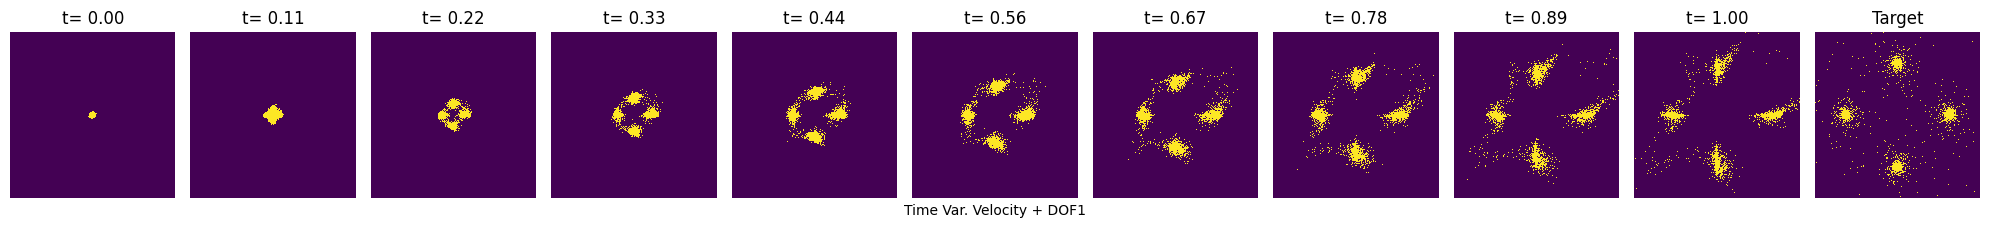

In [58]:

RR=80
fig, axs = plt.subplots(1, 11,figsize=(20,20))

for i in range(11):
    # if i==10:
    #     H = axs[i].hist2d(x_tst[:,0], x_tst[:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)
    # else:
    #     H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    cmin = 0.0
    cmax = 0.99#torch.quantile(torch.from_numpy(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    if i==10:
        _ = axs[i].hist2d(x_tst[:,0], x_tst[:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)
    else:
        _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    if i==10:
        axs[i].set_title('Target')
    else:

        axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
fig.text(0.5, 0.45, 'Time Var. Velocity + DOF'+str(dof_og), ha='center')
plt.show()

In [59]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

# grid_size = 200
# x_1 = torch.meshgrid(torch.linspace(-60, 60, grid_size), torch.linspace(-60, 60, grid_size))
# x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)
x_1=x_tst[0:1000,:].to(device).float()
print(x_1.shape)

torch.Size([1000, 2])


In [60]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p

log_p_acc /= num_acc

# compute with exact divergence
# _, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

In [61]:
print(log_p_acc.mean())
#-3725 rms
# -99 rms
#-14 rms
#-63 adam
#-59.8   or(-45058.3555, d -693.8184, tensor(-50.9519, device='cuda:0') -36 best with decreaseing linear sampling

tensor(-13.7492, device='cuda:0')


In [62]:
from extreme_transforms import softplus
TT = torch.linspace(0,1,10) 
softplus(Tail_paramNet(TT.unsqueeze(1).to(device))[:,0:4])

tensor([[0.1032, 0.0854, 0.2795, 0.1289],
        [0.1901, 0.1599, 0.3914, 0.2370],
        [0.2406, 0.2086, 0.4303, 0.3075],
        [0.2547, 0.2213, 0.4451, 0.3285],
        [0.2667, 0.2286, 0.4622, 0.3374],
        [0.2849, 0.2394, 0.4849, 0.3462],
        [0.3101, 0.2548, 0.5128, 0.3574],
        [0.3425, 0.2757, 0.5444, 0.3722],
        [0.3804, 0.3024, 0.5772, 0.3915],
        [0.4186, 0.3339, 0.6093, 0.4145]], device='cuda:0',
       grad_fn=<SoftplusBackward0>)

In [63]:
# tensor([[0.4239, 0.4793, 0.5323, 0.4701],
#         [0.4258, 0.4814, 0.5359, 0.4732],
#         [0.4278, 0.4836, 0.5397, 0.4765],
#         [0.4299, 0.4858, 0.5436, 0.4798],
#         [0.4322, 0.4882, 0.5477, 0.4832],
#         [0.4345, 0.4907, 0.5518, 0.4867],
#         [0.4369, 0.4932, 0.5559, 0.4902],
#         [0.4394, 0.4959, 0.5602, 0.4937],
#         [0.4420, 0.4985, 0.5645, 0.4973],
#         [0.4446, 0.5012, 0.5688, 0.5009]], device='cuda:0',
#        grad_fn=<SoftplusBackward0>)

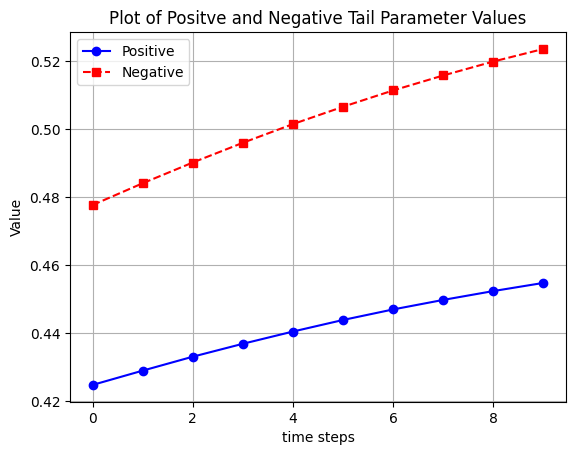

In [64]:
import matplotlib.pyplot as plt

# Given data
data = [[0.4248, 0.4167, 0.4777, 0.4127],
        [0.4290, 0.4229, 0.4841, 0.4221],
        [0.4331, 0.4286, 0.4902, 0.4310],
        [0.4369, 0.4340, 0.4960, 0.4394],
        [0.4405, 0.4390, 0.5015, 0.4472],
        [0.4439, 0.4434, 0.5066, 0.4545],
        [0.4470, 0.4474, 0.5114, 0.4611],
        [0.4498, 0.4509, 0.5158, 0.4672],
        [0.4524, 0.4540, 0.5199, 0.4726],
        [0.4548, 0.4565, 0.5236, 0.4775]]

# Extract first and second columns
first_column = [row[0] for row in data]
second_column = [row[2] for row in data]

# Plot
plt.plot(first_column, marker='o', linestyle='-', color='b', label="Positive")
plt.plot(second_column, marker='s', linestyle='--', color='r', label="Negative")

# Labels and title
plt.xlabel("time steps")
plt.ylabel("Value")
plt.title("Plot of Positve and Negative Tail Parameter Values")
plt.legend()
plt.grid(True)
plt.show()


In [65]:
# K=60
# lv=MultivariateStudentT(torch.tensor(2).float(),torch.tensor([0+K,mean+K]).float(),torch.tensor([[1,0],[0,1]]).float())
# lv.rsample(torch.zeros(4,4).float().shape)

In [66]:
studentT_4_likelihood(objectz,torch.tensor(x_1).cpu()).mean()

C:\Users\adity\AppData\Local\Temp\ipykernel_14980\1121008443.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  studentT_4_likelihood(objectz,torch.tensor(x_1).cpu()).mean()
c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\Distributions2.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob=torch.exp(i.log_prob(torch.tensor(samples)))


tensor(-6.1590)

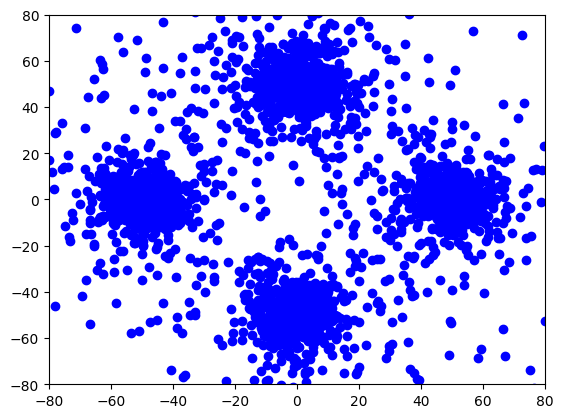

In [67]:

plt.ylim((-80,80))
plt.xlim((-80,80))
plt.scatter(x_tst[:,0],x_tst[:,1],c="blue")
# studentT_4_likelihood(objectz,ST_DATA).mean()

In [68]:
# # torch.log(torch.exp(objectz[3].log_prob(x_1.cpu()))).mean()
# yyy=torch.exp(objectz[0].log_prob(x_1.cpu()))+torch.exp(objectz[1].log_prob(x_1.cpu()))+torch.exp(objectz[2].log_prob(x_1.cpu()))+torch.exp(objectz[3].log_prob(x_1.cpu()))

In [69]:
# torch.log(yyy/4).mean()

In [70]:
torch.rand(x_1.shape[0])

tensor([1.1293e-01, 1.9151e-01, 8.3457e-01, 3.8495e-01, 6.8848e-01, 3.8248e-01,
        7.8213e-01, 9.9483e-01, 3.9872e-01, 4.1079e-01, 7.7514e-01, 1.2262e-01,
        8.2365e-02, 3.3196e-01, 1.4676e-01, 5.0311e-01, 2.4263e-01, 9.3216e-01,
        9.9601e-01, 1.3143e-01, 7.3312e-01, 7.1256e-01, 1.3694e-01, 3.1846e-01,
        3.5734e-01, 8.0650e-02, 2.8869e-01, 7.0711e-01, 9.6939e-01, 8.6394e-01,
        8.0110e-01, 9.7631e-01, 4.6403e-01, 5.3497e-01, 2.5816e-01, 1.3519e-01,
        3.3068e-02, 9.9590e-01, 8.2281e-01, 5.9686e-02, 1.2982e-01, 2.1955e-01,
        5.1056e-01, 6.4529e-01, 1.5502e-01, 3.4108e-01, 6.2566e-01, 1.5318e-01,
        8.7619e-01, 3.5622e-01, 1.5290e-01, 1.8832e-01, 7.7832e-01, 4.3480e-01,
        8.7691e-01, 7.8465e-01, 2.5330e-02, 1.8496e-01, 7.7297e-01, 2.4390e-02,
        6.9707e-01, 7.6525e-01, 4.7525e-01, 3.3436e-01, 1.7953e-01, 6.7244e-01,
        4.8681e-01, 7.1877e-01, 3.1300e-01, 7.6713e-01, 3.0240e-01, 9.7221e-01,
        4.7225e-01, 7.4188e-01, 9.5792e-

In [71]:

'''
# train
start_time = time.time()
for i in range(iterations):
    for data in train_loader:
        optim.zero_grad()
        optim2.zero_grad()
        # sample data : in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
        # print(data[0].shape)
        x_1=data[0].float().to(device)
        x_0 = torch.randn_like(x_1).float().to(device)

        # x_1=data2noiseTransform(x_1_H)[0] #Heavy tail to light tail
       


        # sample time 
        # t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)
        # if i<(3*iterations)//4:
        #     t = 1-torch.sqrt(1-torch.rand(x_1.shape[0])).to(device) #best
        # else:
        #     t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)

        # t = torch.sqrt(torch.rand(x_1.shape[0])).to(device)

        if(predefined_tail_param):
            positive_tail_df=torch.cat([torch.tensor(np.polyval(coeffs_Y1_p,t.cpu())).unsqueeze(1),torch.tensor(np.polyval(coeffs_Y2_p,t.cpu())).unsqueeze(1)],1)
            negative_tail_df=torch.cat([torch.tensor(np.polyval(coeffs_Y1_n,t.cpu())).unsqueeze(1),torch.tensor(np.polyval(coeffs_Y2_n,t.cpu())).unsqueeze(1)],1)
            # print(positive_tail_df.shape) #predefined_tail_param
            positive_tail_param=1/(positive_tail_df+1e-4).to(device)
            negative_tail_param=1/(negative_tail_df+1e-4).to(device)
        # print(positive_tail_param[0:5,:])

        # print(bx)

        # sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        x_t,time_t,dx_t=path_sample.x_t,path_sample.t,path_sample.dx_t
        # print(torch.sum(time_t==t),t.shape)
        # with torch.autograd.detect_anomaly():

        prefinal_vf=vf(x_t,time_t) #BATCH X 2   = dphi_t/ dt
        # print(prefinal_vf.shape,time_t.shape) 
        # print(a)

        param_tail=Tail_paramNet(time_t.unsqueeze(1))  # B X 8 Generating Parameters of Tail net for each time step
        # print("param_tail",softplus(param_tail[0:5,0:4]))  
        # print("fixetail+",positive_tail_param[0:5,:])
        # print("fixetail-",negative_tail_param[0:5,:])
        

        phi_t=noise2data.inverse(x_t,param_tail,predefined_tail_param,positive_tail_param,negative_tail_param)  #phi_t(x_0)
        # print("phi_t",x_t.shape,phi_t.shape) #BATCH X 2
        # print(a)

        
        # Use jacrev to compute the Jacobian for each input
        # print(param_tail)
        jacobian_fn = jacrev(noise2data.forward, argnums=(0, 1))  # Differentiate w.r.t x and y
        if predefined_tail_param:
            ll=0
        else:
            ll=None
        batched_jacobian = vmap(jacobian_fn,in_dims=(0, 0,None,ll,ll))(phi_t, param_tail,predefined_tail_param,positive_tail_param,negative_tail_param)


        # Extract Jacobians w.r.t. x and y
        jacobian_phi, jacobian_param_tail = batched_jacobian
        # print("JACOBION",jacobian_phi.shape,jacobian_param_tail.shape) #BX2X2 BX2X8
        # print(a)
        #delete down
        # jacobian_fn3 = jacrev(noise2data.forward, argnums=(0))
        # jacobian_fn4 = jacrev(noise2data.forward, argnums=( 1))
        # jacobian_phi=vmap(jacobian_fn3)(phi_t, param_tail)
        # jacobian_param_tail=vmap(jacobian_fn4)(phi_t, param_tail)


        #delete up



        jacobian_fn2 = jacrev(Tail_paramNet.forward)  # Differentiate param wrt t
        param_grad = vmap(jacobian_fn2)(time_t.unsqueeze(1)) 
        # print("Param_grad",param_grad.shape) #BX8X1
        

        velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
        # print("VELOCITY field-",velocity_field[:,:,0].shape)

        # print(a)



        # flow matching l2 loss
        
        loss = torch.pow( velocity_field[:,:,0] - dx_t, 2).mean()#/(0.001+torch.abs(dx_t.max()))# remove the max division for math correct
        print(velocity_field.max(),dx_t.max(),loss)


        # optimizer step
        loss.backward() # backward
        optim.step() # update
        optim2.step()
        

    # log loss
        jo=jo+1
        if (jo+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
                .format(jo+1, elapsed*1000/print_every, loss.item()))
            start_time = time.time()
            '''

'\n# train\nstart_time = time.time()\nfor i in range(iterations):\n    for data in train_loader:\n        optim.zero_grad()\n        optim2.zero_grad()\n        # sample data : in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)\n        # print(data[0].shape)\n        x_1=data[0].float().to(device)\n        x_0 = torch.randn_like(x_1).float().to(device)\n\n        # x_1=data2noiseTransform(x_1_H)[0] #Heavy tail to light tail\n       \n\n\n        # sample time \n        # t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)\n        # if i<(3*iterations)//4:\n        #     t = 1-torch.sqrt(1-torch.rand(x_1.shape[0])).to(device) #best\n        # else:\n        #     t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)\n\n        # t = torch.sqrt(torch.rand(x_1.shape[0])).to(device)\n\n        if(predefined_tail_param):\n            positive_tail_df=torch.cat([torch.tensor(np.polyval(coeffs_Y1_p,t.cpu())).u

In [72]:
import numpy as np

# Input vector v (your known partials)
dz1_da1, dz2_da2, dz3_da3,dz1_da4, dz2_da5, dz3_da6,dz1_da7, dz2_da8, dz3_da9,dz1_da10, dz2_da11, dz3_da12=1,2,3,4,5,6,7,8,9,10,11,12
v = np.array([dz1_da1, dz2_da2, dz3_da3,
              dz1_da4, dz2_da5, dz3_da6,
              dz1_da7, dz2_da8, dz3_da9,
              dz1_da10, dz2_da11, dz3_da12])

# Target (row, col) positions in the Jacobian
rows = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])
cols = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
flat_indices = 12 * rows + cols  # Flattened index in 3x12 matrix

# Construct M using pure matrix operations
M = np.zeros((36, 12))
M[flat_indices, np.arange(12)] = 1

# Compute full Jacobian
J = (M @ v).reshape(3, 12)
J

array([[ 1.,  0.,  0.,  4.,  0.,  0.,  7.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  5.,  0.,  0.,  8.,  0.,  0., 11.,  0.],
       [ 0.,  0.,  3.,  0.,  0.,  6.,  0.,  0.,  9.,  0.,  0., 12.]])

In [73]:
import torch
v=list(range(12))
v_batch=torch.zeros(2,12)
v_batch[0]=torch.tensor(v)
v_batch[1]=torch.tensor(v)
v_batch

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]])

In [74]:
B = v_batch.shape[0]  # v_batch should be (B, 12)
dim=3
tail_param_perdim=4
rows=np.array(list(range(dim*tail_param_perdim)))%dim
cols=list(range(dim*tail_param_perdim))
flat_indices = dim*tail_param_perdim * rows + cols  # Flattened index in 3x12 matrix
M = torch.zeros((dim*dim*tail_param_perdim, dim*tail_param_perdim), dtype=v_batch.dtype, device=v_batch.device)

# Compute full Jacobian
M[flat_indices, torch.arange(dim*tail_param_perdim)] = 1.0

# Batched matrix multiply: (B × 36) = (B × 12) @ (12 × 36)ᵀ
J_flat_batch = torch.matmul(v_batch, M.T)  # shape (B, 36)

# Reshape into (B, 3, 12)
J_batch = J_flat_batch.view(-1, dim, dim*tail_param_perdim)
J_batch

tensor([[[ 0.,  0.,  0.,  3.,  0.,  0.,  6.,  0.,  0.,  9.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  4.,  0.,  0.,  7.,  0.,  0., 10.,  0.],
         [ 0.,  0.,  2.,  0.,  0.,  5.,  0.,  0.,  8.,  0.,  0., 11.]],

        [[ 0.,  0.,  0.,  3.,  0.,  0.,  6.,  0.,  0.,  9.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  4.,  0.,  0.,  7.,  0.,  0., 10.,  0.],
         [ 0.,  0.,  2.,  0.,  0.,  5.,  0.,  0.,  8.,  0.,  0., 11.]]])

In [75]:
B = v_batch.shape[0]  # v_batch should be (B, 12)
dim=3
K=v_batch.shape[1]
tail_param_perdim=4
rows=torch.tensor(list(range(dim*tail_param_perdim)))%dim
cols=torch.tensor(list(range(dim*tail_param_perdim)))
flat_indices = dim*tail_param_perdim * rows + cols  # Flattened index in 3x12 matrix
scatter_indices = flat_indices.expand(B, K)  # (B, K)

# Create output buffer
J_flat = torch.zeros((B, dim*dim*tail_param_perdim), dtype=v_batch.dtype)

# Scatter each v_batch[b, :] into the correct flat index positions
J_flat.scatter_(dim=1, index=scatter_indices, src=v_batch)

# Reshape to (B, m, n)
J_batch = J_flat.view(B, dim, dim*tail_param_perdim)
J_batch

tensor([[[ 0.,  0.,  0.,  3.,  0.,  0.,  6.,  0.,  0.,  9.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  4.,  0.,  0.,  7.,  0.,  0., 10.,  0.],
         [ 0.,  0.,  2.,  0.,  0.,  5.,  0.,  0.,  8.,  0.,  0., 11.]],

        [[ 0.,  0.,  0.,  3.,  0.,  0.,  6.,  0.,  0.,  9.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  4.,  0.,  0.,  7.,  0.,  0., 10.,  0.],
         [ 0.,  0.,  2.,  0.,  0.,  5.,  0.,  0.,  8.,  0.,  0., 11.]]])